In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import prince
from scipy.stats import f_oneway, ttest_ind, chi2_contingency, chisquare

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv("D:\Book\H1.csv")

In [3]:
#fill na with 0 for children
dataset['Children'].fillna(0,inplace=True)
monthmap = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
dataset['ArrivalDateMonthNumber'] = dataset['ArrivalDateMonth'].map(monthmap)
dataset['ArrivalDate'] = pd.to_datetime(dataset['ArrivalDateDayOfMonth'].astype(str) + '-' + dataset['ArrivalDateMonth'].astype(str) + '-'+ dataset['ArrivalDateYear'].astype(str))
dataset['ReservationStatusDate']=pd.to_datetime(dataset['ReservationStatusDate'])

dataset['CancelStatus'] = np.where(dataset['IsCanceled']==1,'Canceled','Not Canceled')

In [4]:
#Remove cases where there are no guests. both adults and children is 0 and ADR less than or equal to 0.

dataset=dataset[((dataset['Adults']>0) | (dataset['Children']>0)) &  (dataset['ADR']>0)]
dataset.reset_index(inplace=True,drop=True)

#country feature has few hundred missing values and hence we will remove from analysis.
dataset.dropna(inplace=True)
dataset.reset_index(inplace=True,drop=True)

In [5]:
dataset[dataset.columns[0:14]].head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment
0,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct
1,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate
2,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA
3,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA
4,0,0,2015,July,27,1,0,2,2,0,0,BB,PRT,Direct


In [6]:
dataset[dataset.columns[14:]].head()

,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,CancelStatus
0,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,2015-07-01,Not Canceled
1,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,2015-07-01,Not Canceled
2,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,2015-07-01,Not Canceled
3,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,2015-07-01,Not Canceled
4,Direct,0,0,0,C,C,0,No Deposit,NULL,NULL,0,Transient,107.0,0,0,Check-Out,2015-07-03,7,2015-07-01,Not Canceled


In [7]:
#create booking date
dataset['BookingDate'] = dataset['ArrivalDate'] - pd.to_timedelta(dataset['LeadTime'], unit='d')

##dependent variable
dependent_variable = 'IsCanceled'

##list of numerical features
numerical_features = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children','Babies', 'PreviousCancellations','PreviousBookingsNotCanceled','BookingChanges','DaysInWaitingList','ADR',
'TotalOfSpecialRequests']

##list of categorical features
categorical_features = ['Meal', 'Country', 'MarketSegment', 'DistributionChannel','ReservedRoomType', 'AssignedRoomType','DepositType', 'Agent', 'Company','CustomerType','RequiredCarParkingSpaces','ArrivalDateYear', 'ArrivalDateMonth','ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth','IsRepeatedGuest']

In [8]:
len(numerical_features)

12

## Numerical Features

In [9]:
def describe_stats(dataset,dependent_variable,numerical_feature_name):
    #min,max,1%,5%,25%,50%,75%,95%,99%,max
    result_dict={}
    
    index_list = ['Minimum','1%','5%','25%','Median','75%','95%','99%','Maximum']
    
    dataset_0 = dataset[dataset[dependent_variable]==0]
    dataset_0.reset_index(inplace=True,drop=True)
    
    result_0_Minimum = dataset_0[numerical_feature_name].min()
    result_0_1 = np.round(np.percentile(dataset_0[numerical_feature_name],1),2)
    result_0_5 = np.round(np.percentile(dataset_0[numerical_feature_name],5),2)
    result_0_25 = np.round(np.percentile(dataset_0[numerical_feature_name],25),2)
    result_0_Median = np.round(np.percentile(dataset_0[numerical_feature_name],50),2)
    result_0_75 = np.round(np.percentile(dataset_0[numerical_feature_name],75),2)
    result_0_95 = np.round(np.percentile(dataset_0[numerical_feature_name],95),2)
    result_0_99 = np.round(np.percentile(dataset_0[numerical_feature_name],99),2)
    result_0_Maximum = dataset_0[numerical_feature_name].max()
    list_0 = [result_0_Minimum,result_0_1,result_0_5,result_0_25,result_0_Median,result_0_75,result_0_95,result_0_99,result_0_Maximum]
    
    dataset_1 = dataset[dataset[dependent_variable]==1]
    dataset_1.reset_index(inplace=True,drop=True)
    result_1_Minimum = dataset_1[numerical_feature_name].min()
    result_1_1 = np.round(np.percentile(dataset_1[numerical_feature_name],1),2)
    result_1_5 = np.round(np.percentile(dataset_1[numerical_feature_name],5),2)
    result_1_25 = np.round(np.percentile(dataset_1[numerical_feature_name],25),2)
    result_1_Median = np.round(np.percentile(dataset_1[numerical_feature_name],50),2)
    result_1_75 = np.round(np.percentile(dataset_1[numerical_feature_name],75),2)
    result_1_95 = np.round(np.percentile(dataset_1[numerical_feature_name],95),2)
    result_1_99 = np.round(np.percentile(dataset_1[numerical_feature_name],99),2)
    result_1_Maximum = dataset_1[numerical_feature_name].max()
    list_1 = [result_1_Minimum,result_1_1,result_1_5,result_1_25,result_1_Median,result_1_75,result_1_95,result_1_99,result_1_Maximum]
    
    dataResult = pd.DataFrame(data={'IsCanceledNo':list_0,'IsCanceledYes':list_1},index=index_list)    

    return dataResult


def four_plots(numerical_features):
    
    sns.set(rc={'figure.figsize':(20,20)})
    sns.set(style="darkgrid")
    sns.set_context('paper', font_scale = 1.5)
    
    fig, axs = plt.subplots(ncols=2,nrows=2)
    fig.subplots_adjust(hspace=0.3)

    index = 0
    for rows in range(2):
        for columns in range(2):
            if index < len(numerical_features):
                desc_df = describe_stats(dataset,dependent_variable,numerical_features[index])
                axes = axs[rows,columns]
                axes.plot(desc_df.index.values,desc_df['IsCanceledNo'].values)#,marker='o',s = 50)
                axes.plot(desc_df.index.values,desc_df['IsCanceledYes'].values)#,marker='o',s = 50)
                axes.set_xticklabels(labels = desc_df.index,rotation=90)
                axes.legend(('IsCanceledNo','IsCanceledYes'))#loc='lower right')
                axes.set_title(numerical_features[index])
            index+=1


def one_plots(numerical_features):

    
    sns.set(rc={'figure.figsize':(8,8)})
    sns.set(style="darkgrid")
    sns.set_context('paper', font_scale = 1.5)
    
    fig, axes = plt.subplots(ncols=1)
    fig.subplots_adjust(hspace=0.3)

    index = 0

    desc_df = describe_stats(dataset,dependent_variable,numerical_features[index])
#     axes = axs[0]
    axes.plot(desc_df.index.values,desc_df['IsCanceledNo'].values)#,marker='o',s = 50)
    axes.plot(desc_df.index.values,desc_df['IsCanceledYes'].values)#,marker='o',s = 50)
    axes.set_xticklabels(labels = desc_df.index,rotation=90)
    axes.legend(('IsCanceledNo','IsCanceledYes'))#loc='lower right')
    axes.set_title(numerical_features[index])


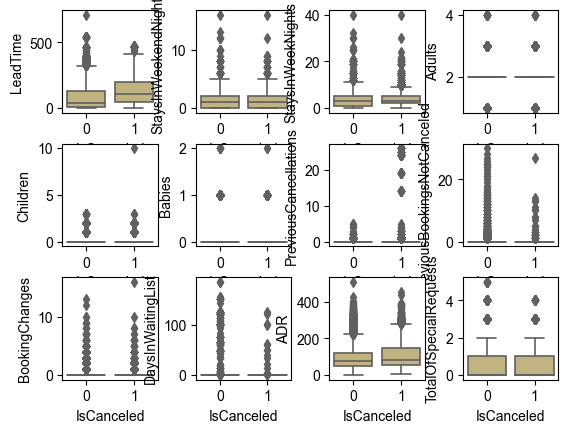

In [10]:
fig, axs = plt.subplots(ncols=4,nrows=3)
fig.subplots_adjust(wspace=0.4,hspace=0.3)

sns.set(rc={'figure.figsize':(16,12)})
sns.set(style="darkgrid")
sns.set_context('paper', font_scale = 1.3)
color = 'y'
pal = {0:color,1:color}

index = 0
for rows in range(3):
    for columns in range(4):
        #bargraph of dependent variable
        if index < len(numerical_features):
            sns.boxplot(x = dependent_variable, y = numerical_features[index], data = dataset,palette=pal, ax=axs[rows,columns])
            index+=1


In [11]:
pd.crosstab(dataset['IsCanceled'],dataset['LeadTime'])

LeadTime,0,1,2,3,4,5,6,7,8,9,...,445,450,454,460,462,468,471,532,542,709
IsCanceled,,,,,,,,,,,,,,,,,,,,,
0,2837,1382,796,693,582,506,458,489,308,284,...,3,0,1,3,0,17,0,1,22,1
1,143,85,84,61,40,50,34,51,56,64,...,0,1,0,0,20,28,6,0,0,0


In [12]:
pd.crosstab(dataset['IsCanceled'],dataset['Children'])

Children,0,1,2,3,10
IsCanceled,,,,,
0,25739,1252,855,15,0
1,9684,555,753,2,1


In [13]:
dataset[dataset['PreviousCancellations']>5]['IsCanceled'].value_counts()

1    132
Name: IsCanceled, dtype: int64

In [14]:
dataset[dataset['PreviousBookingsNotCanceled']>14]['IsCanceled'].value_counts()

0    25
1     1
Name: IsCanceled, dtype: int64

In [15]:
dataset[dataset['DaysInWaitingList']>121]['IsCanceled'].value_counts()

0    74
1     1
Name: IsCanceled, dtype: int64

In [16]:
pd.crosstab(dataset['IsCanceled'],dataset['TotalOfSpecialRequests'])

TotalOfSpecialRequests,0,1,2,3,4,5
IsCanceled,,,,,,
0,14464,8956,3583,720,126,12
1,7117,2581,1118,164,15,0


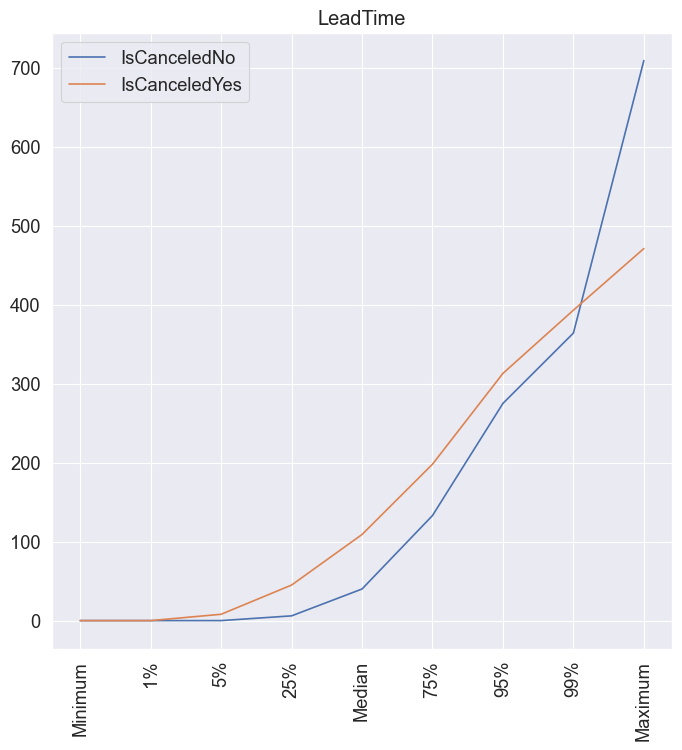

In [17]:
one_plots([numerical_features[0]])

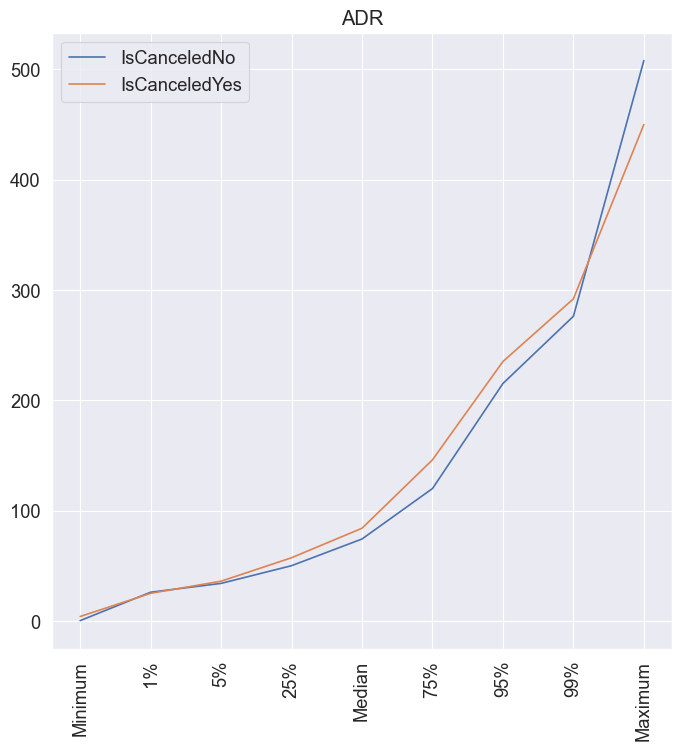

In [18]:
one_plots([numerical_features[-2]])

In [19]:

#children is more than 3
dataset['ChildrenMoreThan3']=np.where(dataset['Children']>3,1,0)

#more than 5 cancellations by the same guest in the past
dataset['PreviousCancellationsMoreThan5']=np.where(dataset['PreviousCancellations']>5,1,0)

#did not cancel more than 14 times in the past
dataset['PreviousBookingsNotCanceledMoreThan14']=np.where(dataset['PreviousBookingsNotCanceled']>14,1,0)

#waiting list for more than 121 days
dataset['DaysInWaitingListMoreThan121']=np.where(dataset['DaysInWaitingList']>121,1,0)

#more than 4 special requests
dataset['TotalOfSpecialRequestsMoreThan4']=np.where(dataset['TotalOfSpecialRequests']>4,1,0)

In [20]:
new_categoricalfeatures = ['ChildrenMoreThan3','PreviousCancellationsMoreThan5','PreviousBookingsNotCanceledMoreThan14','DaysInWaitingListMoreThan121','TotalOfSpecialRequestsMoreThan4']
len(new_categoricalfeatures)

5

In [21]:
### ChildrenMoreThan3

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['ChildrenMoreThan3'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.6299283829983215
Accept null hypothesis! There is no relationship between two variables.


In [22]:
### PreviousCancellationsMoreThan5

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['PreviousCancellationsMoreThan5'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.000000000000000000000000000000000000000000000000000000000000000000000000033737971571403955
Reject null hypothesis! There is relationship between two variables and the feature is useful.


In [23]:
### PreviousBookingsNotCanceledMoreThan14

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['PreviousBookingsNotCanceledMoreThan14'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.010741832089281714
Reject null hypothesis! There is relationship between two variables and the feature is useful.


In [24]:
### DaysInWaitingListMoreThan121

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['DaysInWaitingListMoreThan121'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.0000004176073675972267
Reject null hypothesis! There is relationship between two variables and the feature is useful.


In [25]:
### TotalOfSpecialRequestsMoreThan4

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['TotalOfSpecialRequestsMoreThan4'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.0634527324644697
Accept null hypothesis! There is no relationship between two variables.


### Categorical

- Lets identify features which has categories more than 50% for both class of dependent variable

In [26]:
def find_categories(dataset,categorical_features,index):
    crosstab = np.round(pd.crosstab(dataset[categorical_features[index]],dataset['IsCanceled'], normalize='index')*100)
    zero = crosstab[crosstab[0]>50].shape[0]
    one = crosstab[crosstab[1]>50].shape[0]
    return (zero >= 1 and one >= 1 and dataset[categorical_features[index]].nunique()>2)

In [27]:
for index in range(len(categorical_features)):
    if find_categories(dataset,categorical_features,index):
        print('Feature',categorical_features[index],'of index:'+str(index),'has categories more than 50% for both class of dependent variable')

Feature Meal of index:0 has categories more than 50% for both class of dependent variable
Feature Country of index:1 has categories more than 50% for both class of dependent variable
Feature AssignedRoomType of index:5 has categories more than 50% for both class of dependent variable
Feature DepositType of index:6 has categories more than 50% for both class of dependent variable
Feature Agent of index:7 has categories more than 50% for both class of dependent variable
Feature Company of index:8 has categories more than 50% for both class of dependent variable


In [28]:
index = 0
pd.crosstab(dataset[categorical_features[index]],dataset['CancelStatus'])

CancelStatus,Canceled,Not Canceled
Meal,,
BB,7737,21296
FB,442,303
HB,2532,5395
SC,0,23
Undefined,284,844


In [29]:
index = 1
pd.crosstab(dataset[categorical_features[index]],dataset['CancelStatus'])

CancelStatus,Canceled,Not Canceled
Country,,
AGO,7,15
ALB,1,2
AND,3,2
ARE,8,3
ARG,9,48
...,...,...
VEN,1,2
VNM,0,2
ZAF,5,13


In [30]:
#negligible class difference, consideriing category 'L' has only 1 value. Hence excluded from further analysis
index = 5
pd.crosstab(dataset[categorical_features[index]],dataset['CancelStatus'])

CancelStatus,Canceled,Not Canceled
AssignedRoomType,,
A,5971,10688
B,9,145
C,424,1734
D,2070,7983
E,1416,4088
F,201,1469
G,648,1154
H,251,445
I,4,155


In [31]:
index = 6
pd.crosstab(dataset[categorical_features[index]],dataset['CancelStatus'])

CancelStatus,Canceled,Not Canceled
DepositType,,
No Deposit,9323,27672
Non Refund,1650,69
Refundable,22,120


In [32]:
index = 7
pd.crosstab(dataset[categorical_features[index]],dataset['CancelStatus'])

CancelStatus,Canceled,Not Canceled
Agent,,
1,50,4
2,7,95
3,4,24
5,47,176
6,54,534
...,...,...
526,1,9
527,0,35
531,46,21


In [33]:
#too many cateog
index = 8
pd.crosstab(dataset[categorical_features[index]],dataset['CancelStatus'])

CancelStatus,Canceled,Not Canceled
Company,,
6,0,1
9,2,10
10,0,1
12,0,13
14,0,2
...,...,...
534,0,2
539,0,2
541,0,1


In [34]:
def recode_categories(dataset,feature_name):
    crosstab = np.round(pd.crosstab(dataset[feature_name],dataset['CancelStatus'], normalize='index')*100)
    zero = crosstab[crosstab['Not Canceled']>50].index.values
    one = crosstab[crosstab['Canceled']>50].index.values
    
    dataset[feature_name+'_Recoded'] = np.where(dataset[feature_name].isin(one),'One','Zero')
    
    return zero,one,dataset

In [35]:
## create binary features
zero_Country,one_Country,dataset = recode_categories(dataset,feature_name='Country')
zero_Agent,one_Agent,dataset = recode_categories(dataset,feature_name='Agent')
zero_Company,one_Company,dataset = recode_categories(dataset,feature_name='Company')

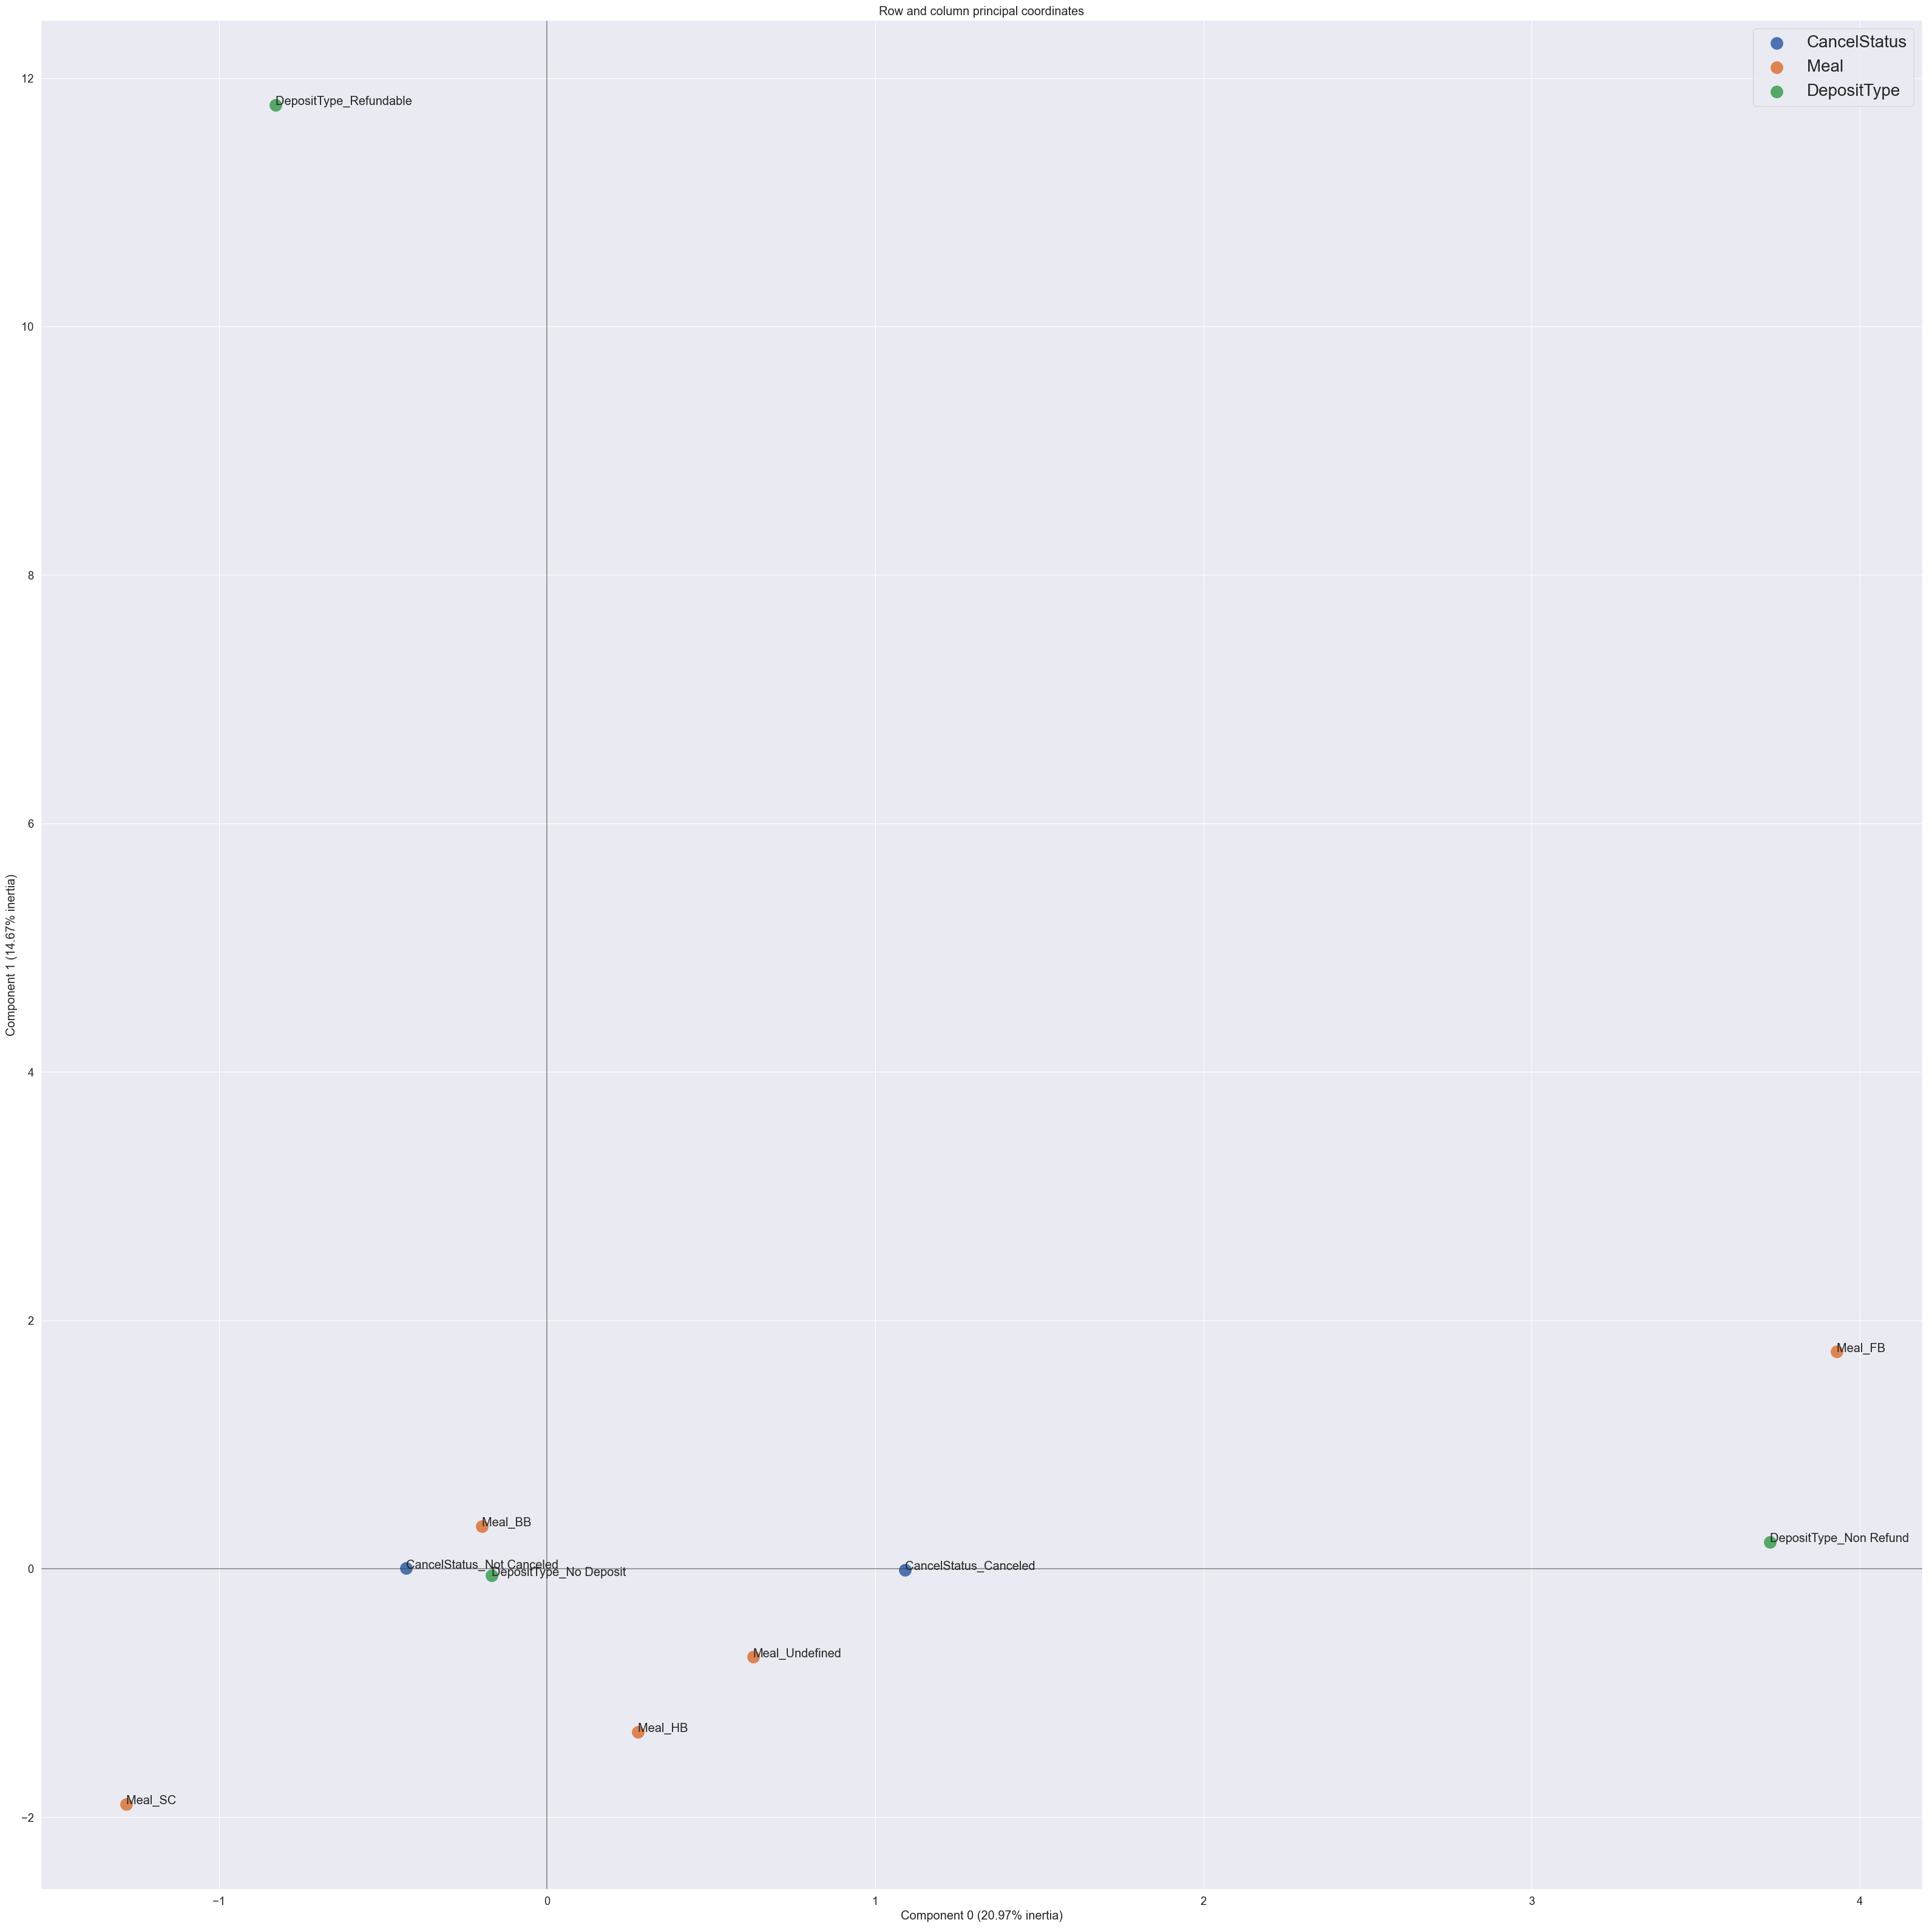

In [36]:
column=['Meal','DepositType']#,'Country_Recoded', 'Agent_Recoded','Company_Recoded']
#,
# ,'Country', 'Agent', 'Company'

# column=['Country']

dataset_mc = dataset[['CancelStatus']+column]
mc = prince.MCA(n_components=2,n_iter=100,copy=True,check_input=True,engine='auto',random_state=10)
mc_model = mc.fit(dataset_mc)

ax = mc_model.plot_coordinates(X=dataset_mc,ax=None,figsize=(40, 40),show_row_points=False,row_points_size=0,
        show_row_labels=False,show_column_points=True,column_points_size=200,show_column_labels=True,legend_n_cols=50).legend(loc='best', bbox_to_anchor=(1, 1),fontsize=20)

plt.grid(b=None)


#### Chi-square test for 4 created features

In [37]:
#create feature from correspondence analysis findings
#customers who either did bead and breakfast or who did not deposit any sum while making reservations

dataset['LessCancellation'] = np.where(((dataset['Meal']=='BB       ') | (dataset['DepositType']=='No Deposit       ')),1,0)


In [38]:
### Country_Recoded

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['Country_Recoded'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.0000000000018967970752340163
Reject null hypothesis! There is relationship between two variables and the feature is useful.


In [39]:
### Agent_Recoded

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['Agent_Recoded'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0
Reject null hypothesis! There is relationship between two variables and the feature is useful.


In [40]:
### Company_Recoded

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['Company_Recoded'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.00000000410969116507584
Reject null hypothesis! There is relationship between two variables and the feature is useful.


In [41]:
### LessCancellation

stat, p, dof, expected=chi2_contingency(pd.crosstab(dataset['LessCancellation'], dataset['CancelStatus']))
alpha = 0.05
print("p value is " + str(np.format_float_positional(p, trim='-')))
if round(p,2) <= alpha:
    print('Reject null hypothesis! There is relationship between two variables and the feature is useful.')
else:
    print('Accept null hypothesis! There is no relationship between two variables.')

p value is 0.00000000000000000000000000000000003184550925718439
Reject null hypothesis! There is relationship between two variables and the feature is useful.


In [42]:
'Country_Recoded', 'Agent_Recoded','Company_Recoded'

('Country_Recoded', 'Agent_Recoded', 'Company_Recoded')